Objetivo: entender padrões do dataset Telco Churn e preparar dados para modelagem

Churn = perda de clientes

In [3]:
# carregar dados
import pandas as pd

df = pd.read_csv("../data/raw/telco_churn.csv")
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


- Diagnóstico inicial dos dados

In [4]:
# informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df.shape

(7043, 21)

In [22]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# numeros de valores distintos por coluna
nunique = df.nunique().sort_values()
nunique

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PhoneService           2
PaperlessBilling       2
Churn                  2
MultipleLines          3
TechSupport            3
StreamingTV            3
OnlineBackup           3
DeviceProtection       3
StreamingMovies        3
Contract               3
OnlineSecurity         3
InternetService        3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6530
customerID          7043
dtype: int64

In [27]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["TotalCharges"].isnull().sum()

np.int64(11)

In [11]:
# definindo target
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [ ]:
# verificando proporção
df["Churn"].value_counts(normalize=True) * 100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

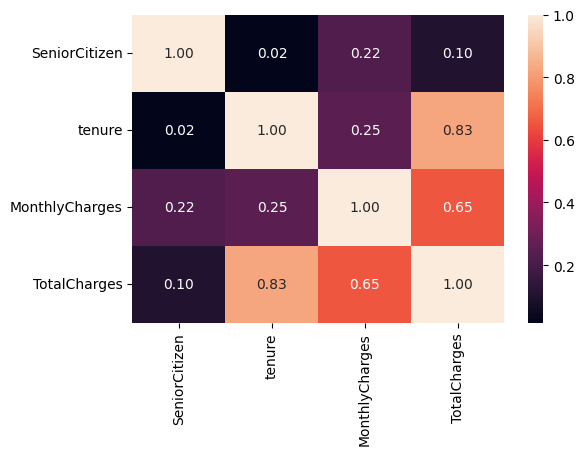

In [18]:
# correlações numéricas 
num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

- Storytelling


1. Qual contrato tem maior risco de Churn?

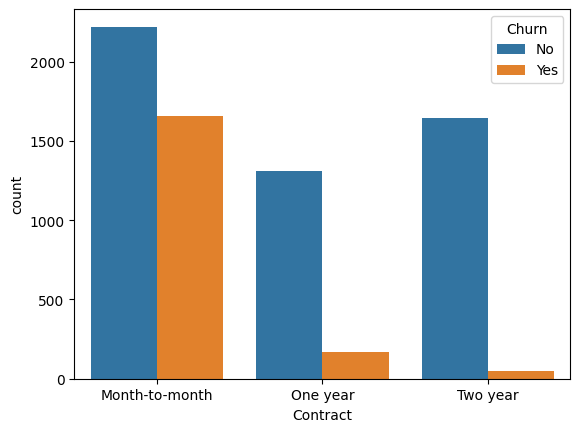

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# churn por tipo de contrato
sns.countplot(x="Contract", hue="Churn", data=df)
plt.show()

In [31]:
churn_rate = (df.assign(churn_bin=(df["Churn"]=="Yes").astype(int))
              .groupby("Contract")["churn_bin"].mean()
              .sort_values(ascending=False) * 100)

churn_rate


Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: churn_bin, dtype: float64

O contrato mensal tem churn rate maior, o que aumenta riscos. Ação: criar campanha de migração para contrato anual

2. O churn é maior no início do relacionamento?

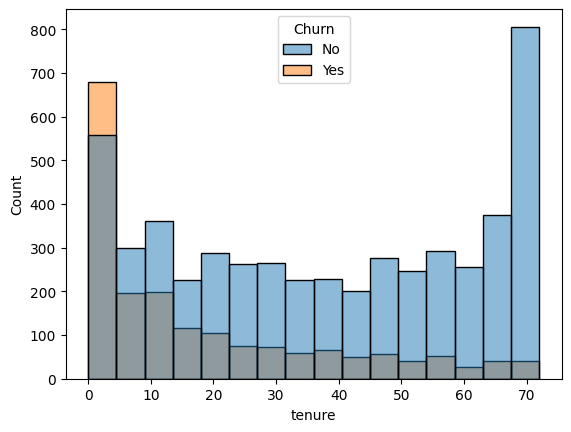

In [41]:
sns.histplot(data=df, x="tenure", hue="Churn")
plt.show()

In [42]:
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[-1, 6, 12, 24, 48, 72],
    labels=["0-6", "7-12", "13-24", "25-48", "49-72"]
)

rate_tenure = (df.assign(churn_bin=(df["Churn"]=="Yes").astype(int))
               .groupby("tenure_group")["churn_bin"].mean() * 100)

rate_tenure

C:\Users\Tereza\AppData\Local\Temp\ipykernel_1888\1765033105.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("tenure_group")["churn_bin"].mean() * 100)


tenure_group
0-6      52.937205
7-12     35.886525
13-24    28.710938
25-48    20.388959
49-72     9.513176
Name: churn_bin, dtype: float64

Sim, clientes em fase inicial tem mais chances de churn. Ação: mais ofertas nos primeiros meses

3. MonthlyCharges maior está associado a churn?

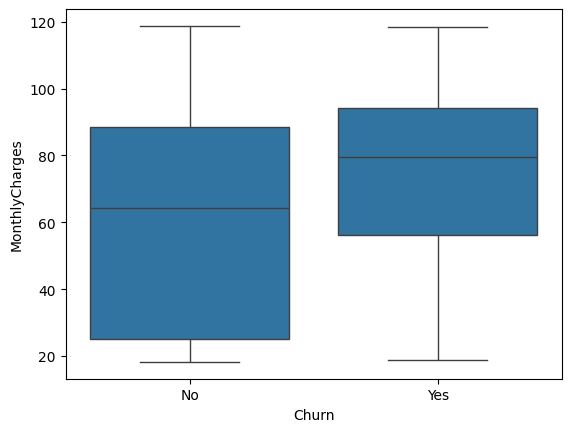

In [49]:
sns.boxplot(data=df, y="MonthlyCharges", x="Churn")
plt.show()

In [50]:
df.groupby("Churn")["MonthlyCharges"].mean()

Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

Clientes que tiveram churn em sua maioria, tem cobrança mensal maior. Ação: Tentar desconto personalizado

4. Qual método de pagamento é mais arriscado?

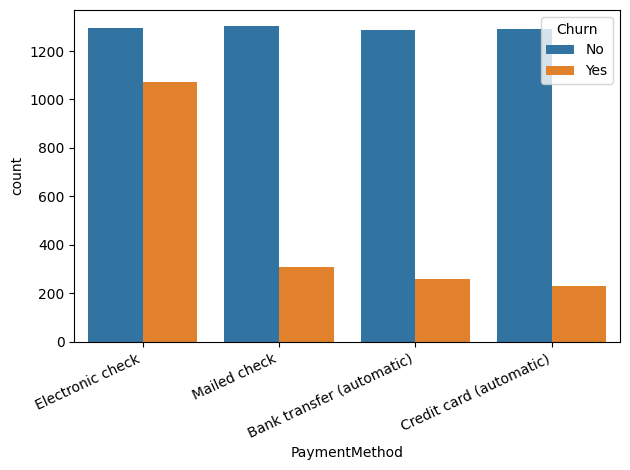

In [58]:
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

In [52]:
rate_pay = (df.assign(churn_bin=(df["Churn"]=="Yes").astype(int))
              .groupby("PaymentMethod")["churn_bin"].mean()
              .sort_values(ascending=False) * 100)

rate_pay

PaymentMethod
Electronic check             45.285412
Mailed check                 19.106700
Bank transfer (automatic)    16.709845
Credit card (automatic)      15.243101
Name: churn_bin, dtype: float64

Cheque eletrônico tem mais churns. Ação: incentivar migração para débito automático

5. Qual serviço de internet tem maior churn?

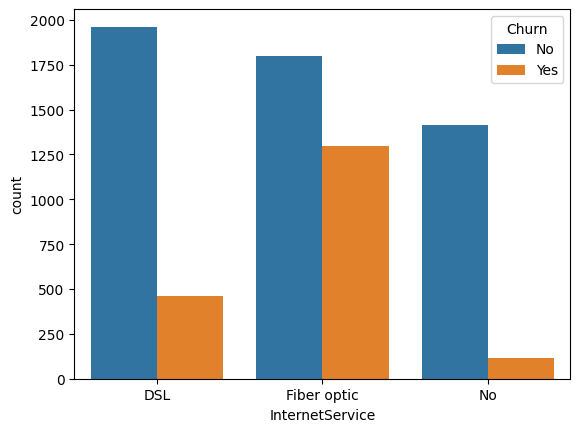

In [59]:
sns.countplot(data=df, x="InternetService", hue="Churn")
plt.show()

In [60]:
rate_service = (df.assign(churn_bin=(df["Churn"]=="Yes").astype(int))
              .groupby("InternetService")["churn_bin"].mean()
              .sort_values(ascending=False) * 100)

rate_service

InternetService
Fiber optic    41.892765
DSL            18.959108
No              7.404980
Name: churn_bin, dtype: float64

Fibra ótica se destaca com mais churn. Ação: investigar performance do serviço.

6. Existe um “perfil de alto risco” combinando 2 variáveis?

In [61]:
pivot = pd.crosstab(df["Contract"], df["InternetService"], values=(df["Churn"]=="Yes"), aggfunc="mean") * 100
pivot

InternetService,DSL,Fiber optic,No
Contract,,,
Month-to-month,32.215863,54.605263,18.893130
One year,9.298246,19.294991,2.472527
Two year,1.910828,7.226107,0.783699


Contrato mensal + fibra ótico é a combinação mais propícia a churn. Ação: segmentar campanhas.

7. Qual variável parece mais “explicativa” do churn?

Pelos gráficos já gerados (entre churn e contrato, tenure e monthlychanges), contract e tenure apresentam separação mais forte. Devem ser prioritárias para o baseline.

## Resumo executivo


O churn representa 26,5% da base. Observamos maior risco em contratos mensais, principalmente em clientes com baixo tenure e MonthlyCharges mais altos. Recomenda-se focar retenção nos primeiros meses e oferecer incentivos para migração para contratos longos.